In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from google.colab import files
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *
import warnings

warnings.filterwarnings("ignore")

I used the following Javacript command to grab image urls from Google image and save them locally as a CSV file:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

Then I proceed to upload the url files to Google Colab

In [36]:
uploaded = files.upload()

Saving Weather.zip to Weather.zip


In [37]:
!unzip Weather.zip

Archive:  Weather.zip
   creating: Weather/rain/
  inflating: Weather/rain/urls_rain.csv  
   creating: Weather/snow/
  inflating: Weather/snow/urls_snow.csv  
   creating: Weather/sunny/
  inflating: Weather/sunny/urls_sunny.csv  


Next step is to define a function that creates a directory to store all the images of each class

In [0]:
def create_data(folder, filename):
  #Create directory
  path = Path("Weather")
  dest = path/folder
  Path(dest).mkdir(parents=True, exist_ok=True)

  #Download images to directory
  download_images(path/folder/filename, dest, max_pics=20, max_workers=0)

In [55]:
folder = "rain"
filename = "urls_rain.csv"
create_data(folder, filename)

In [56]:
folder = "snow"
filename = "urls_snow.csv"
create_data(folder, filename)

In [79]:
folder = "sunny"
filename = "urls_sunny.csv"
create_data(folder, filename)

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

"Invalid URL" errors are due to the fact that the javascript command that we ran to get the image urls is not perfect and many times outputs empty strings.

The next step is to verify all the images for each class and delete those that are corrupted

In [65]:
classes = ["rain", "snow", "sunny"]
for c in classes:
    path_class = Path("Weather/" + c)
    print(c)
    verify_images(path_class, delete=True, max_size=500, max_workers=8)

rain


snow


sunny


Now we resize, normalize, and split our images into their classes. Additionally we create a validation set using 20% of our images. Note: The random seed is for reproducibility.

In [0]:
path = "Weather/"
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=64).normalize(imagenet_stats)

In [74]:
data.classes

['rain', 'snow', 'sunny']

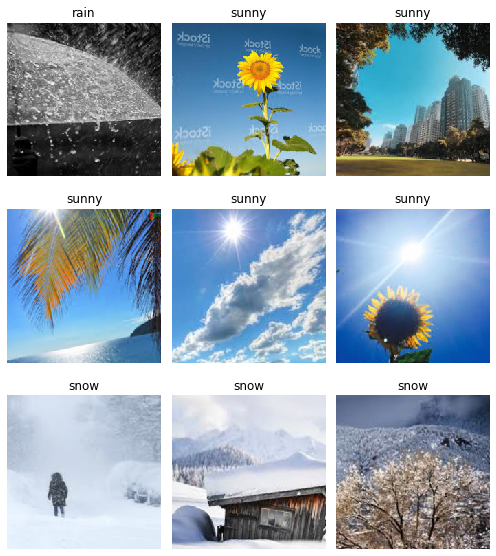

In [77]:
data.show_batch(rows=3, figsize=(7,8))

In [82]:
print("Images in Training Set: {}".format(len(data.train_ds)))
print("Images in Validation Set: {}".format(len(data.valid_ds)))

Images in Training Set: 384
Images in Validation Set: 96


We create our model using ResNes 34, and fit it to our data using 5 epochs

In [83]:
model = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 19.8MB/s]


In [84]:
model.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.641770,0.734157,0.239583,02:20
1,0.990071,0.685410,0.145833,02:21
2,0.686273,0.508060,0.135417,02:20
3,0.546939,0.398664,0.125000,02:21
4,0.454592,0.371083,0.114583,02:21


In [0]:
model.save("stage-1")

Now that we have a baseline, we should proceed to improve our model. One way of trying to decrease our error rate is to find and use and optimal learning rate.

In [0]:
model.unfreeze()

In [88]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


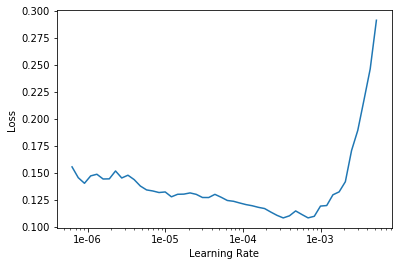

In [89]:
model.recorder.plot()

Now we fit our data using 2 epochs and limiting our learning rate to an interval were the loss values decrease.

In [92]:
model.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.138151,0.341820,0.062500,03:25
1,0.128983,0.381160,0.083333,03:23


In [0]:
model.save("stage-2")

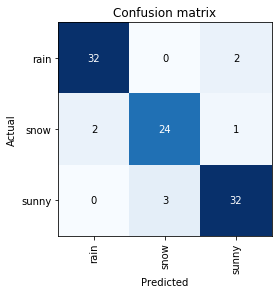

In [94]:
results = ClassificationInterpretation.from_learner(model)
results.plot_confusion_matrix()

We were able to reduce our error rate to 8.3%, but we could further reduce it by cleaning our noisy dataset